In [1]:
from os.path import exists
git_repo_url = 'https://github.com/fizyr/keras-retinanet'
retina_net_dir = 'keras-retinanet'
if not exists(retina_net_dir):
    !git clone -q --recurse-submodules --depth 1 $git_repo_url
    !cd {retina_net_dir} && pip install .

Processing c:\users\91906\desktop\pro\keras-retinanet
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
  Created wheel for keras-retinanet: filename=keras_retinanet-1.0.0-cp39-cp39-win_amd64.whl size=128302 sha256=71d36c9eefbd0903ff1725521f37f71bdf079d9765fbe053a63903ef18ce4a7d
  Stored in directory: c:\users\91906\appdata\local\pip\cache\wheels\bd\4b\0b\58110c66af2f7d7dd85a528694a90016f4e75e7a2e3961f0de
Successfully built keras-retinanet
  Attempting uninstall: keras-retinanet
    Found existing installation: keras-retinanet 1.0.0
    Uninstalling keras-retinanet-1.0.0:
      Successfully uninstalled keras-retinanet-1.0.0


In [2]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
import keras
from keras_retinanet import models
from keras_retinanet.utils.image import read_image_bgr, preprocess_image, resize_image
from keras_retinanet.utils.visualization import draw_box, draw_caption
from keras_retinanet.utils.colors import label_color
import matplotlib.pyplot as plt
import cv2
import os
import numpy as np
import time
import tensorflow as tf
def get_session():
    config = tf.ConfigProto()
    config.gpu_options.allow_growth = True
    return tf.Session(config=config)
import tensorflow.keras.backend as K

In [3]:
model_path = os.path.join('snapshots', 'version8_resplit_test_train', 'resnet50_csv_12_inference.h5')
model = models.load_model(model_path, backbone_name='resnet50')
print(model.summary())
labels_to_names = {0: 'Biker', 1: 'Car', 2: 'Bus', 3: 'Cart', 4: 'Skater', 5: 'Pedestrian'}

Model: "retinanet-bbox"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, None, None,  0           []                               
                                 3)]                                                              
                                                                                                  
 padding_conv1 (ZeroPadding2D)  (None, None, None,   0           ['input_1[0][0]']                
                                3)                                                                
                                                                                                  
 conv1 (Conv2D)                 (None, None, None,   9408        ['padding_conv1[0][0]']          
                                64)                                                  

                                256)                                                              
                                                                                                  
 bn2b_branch2c (BatchNormalizat  (None, None, None,   1024       ['res2b_branch2c[0][0]']         
 ion)                           256)                                                              
                                                                                                  
 res2b (Add)                    (None, None, None,   0           ['bn2b_branch2c[0][0]',          
                                256)                              'res2a_relu[0][0]']             
                                                                                                  
 res2b_relu (Activation)        (None, None, None,   0           ['res2b[0][0]']                  
                                256)                                                              
          

 res3b_branch2a (Conv2D)        (None, None, None,   65536       ['res3a_relu[0][0]']             
                                128)                                                              
                                                                                                  
 bn3b_branch2a (BatchNormalizat  (None, None, None,   512        ['res3b_branch2a[0][0]']         
 ion)                           128)                                                              
                                                                                                  
 res3b_branch2a_relu (Activatio  (None, None, None,   0          ['bn3b_branch2a[0][0]']          
 n)                             128)                                                              
                                                                                                  
 padding3b_branch2b (ZeroPaddin  (None, None, None,   0          ['res3b_branch2a_relu[0][0]']    
 g2D)     

                                                                                                  
 res3d_branch2b_relu (Activatio  (None, None, None,   0          ['bn3d_branch2b[0][0]']          
 n)                             128)                                                              
                                                                                                  
 res3d_branch2c (Conv2D)        (None, None, None,   65536       ['res3d_branch2b_relu[0][0]']    
                                512)                                                              
                                                                                                  
 bn3d_branch2c (BatchNormalizat  (None, None, None,   2048       ['res3d_branch2c[0][0]']         
 ion)                           512)                                                              
                                                                                                  
 res3d (Ad

                                1024)                             'res4a_relu[0][0]']             
                                                                                                  
 res4b_relu (Activation)        (None, None, None,   0           ['res4b[0][0]']                  
                                1024)                                                             
                                                                                                  
 res4c_branch2a (Conv2D)        (None, None, None,   262144      ['res4b_relu[0][0]']             
                                256)                                                              
                                                                                                  
 bn4c_branch2a (BatchNormalizat  (None, None, None,   1024       ['res4c_branch2a[0][0]']         
 ion)                           256)                                                              
          

 res4e_branch2b (Conv2D)        (None, None, None,   589824      ['padding4e_branch2b[0][0]']     
                                256)                                                              
                                                                                                  
 bn4e_branch2b (BatchNormalizat  (None, None, None,   1024       ['res4e_branch2b[0][0]']         
 ion)                           256)                                                              
                                                                                                  
 res4e_branch2b_relu (Activatio  (None, None, None,   0          ['bn4e_branch2b[0][0]']          
 n)                             256)                                                              
                                                                                                  
 res4e_branch2c (Conv2D)        (None, None, None,   262144      ['res4e_branch2b_relu[0][0]']    
          

                                                                                                  
 bn5a_branch1 (BatchNormalizati  (None, None, None,   8192       ['res5a_branch1[0][0]']          
 on)                            2048)                                                             
                                                                                                  
 res5a (Add)                    (None, None, None,   0           ['bn5a_branch2c[0][0]',          
                                2048)                             'bn5a_branch1[0][0]']           
                                                                                                  
 res5a_relu (Activation)        (None, None, None,   0           ['res5a[0][0]']                  
                                2048)                                                             
                                                                                                  
 res5b_bra

                                256)                                                              
                                                                                                  
 P4_merged (Add)                (None, None, None,   0           ['P5_upsampled[0][0]',           
                                256)                              'C4_reduced[0][0]']             
                                                                                                  
 P4_upsampled (UpsampleLike)    (None, None, None,   0           ['P4_merged[0][0]',              
                                256)                              'res3d_relu[0][0]']             
                                                                                                  
 C3_reduced (Conv2D)            (None, None, None,   131328      ['res3d_relu[0][0]']             
                                256)                                                              
          

Total params: 36,555,832
Trainable params: 12,994,680
Non-trainable params: 23,561,152
__________________________________________________________________________________________________
None


In [47]:
sdd_images = os.listdir('imgs/train')
print(sdd_images)

['bookstore_video0_120.jpg', 'bookstore_video0_160.jpg', 'bookstore_video0_200.jpg', 'bookstore_video0_240.jpg', 'bookstore_video0_280.jpg', 'bookstore_video0_320.jpg', 'bookstore_video0_360.jpg', 'bookstore_video0_40.jpg', 'bookstore_video0_400.jpg', 'bookstore_video0_440.jpg', 'bookstore_video0_480.jpg', 'bookstore_video0_80.jpg', 'desktop.ini']


In [48]:
def run_detection_image(filepath):
    image = read_image_bgr(filepath)
    draw = image.copy()
    draw = cv2.cvtColor(draw, cv2.COLOR_BGR2RGB)
    image = preprocess_image(image)
    image, scale = resize_image(image)
    start = time.time()
    boxes, scores, labels = model.predict_on_batch(np.expand_dims(image, axis=0))
    print("processing time: ", time.time() - start)
    boxes /= scale
    for box, score, label in zip(boxes[0], scores[0], labels[0]):
        if score < 0.5:
            break
        color = label_color(label)
        b = box.astype(int)
        draw_box(draw, b, color=color)
        caption = "{} {:.3f}".format(labels_to_names[label], score)
        draw_caption(draw, b, caption)
    plt.figure(figsize=(15, 15))
    plt.axis('off')
    plt.imshow(draw)
    plt.show()
    file, ext = os.path.splitext(filepath)
    image_name = file.split('/')[-1] + ext
    output_path = os.path.join('imgs/train', image_name)  
    draw_conv = cv2.cvtColor(draw, cv2.COLOR_BGR2RGB)
    cv2.imwrite(output_path, draw_conv)

processing time:  1.94627046585083


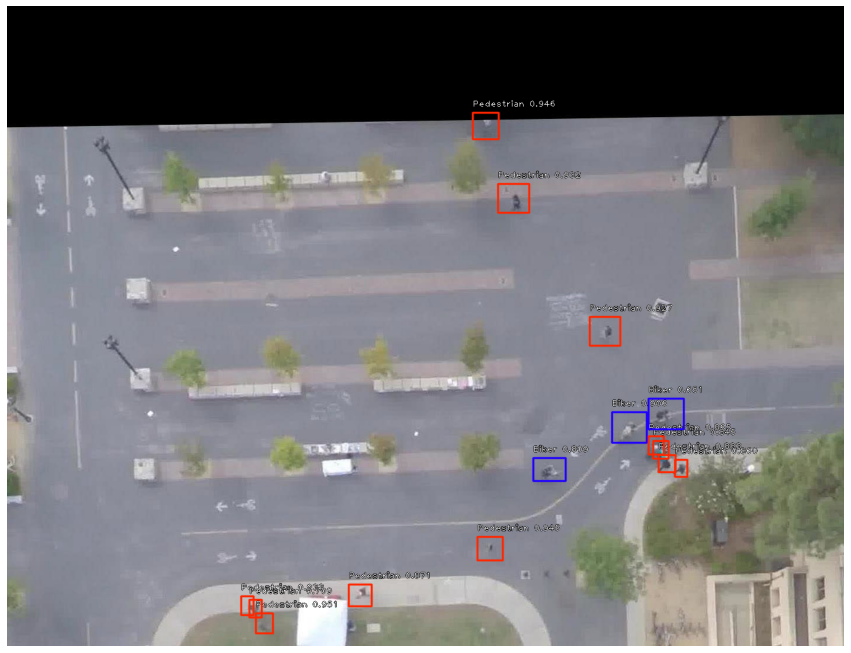

processing time:  1.5163829326629639


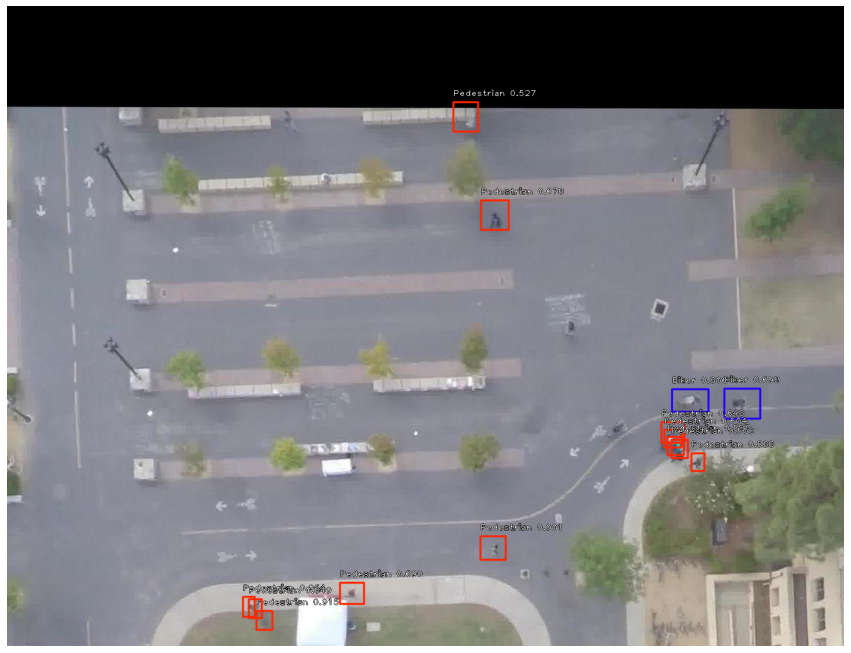

processing time:  1.6049127578735352


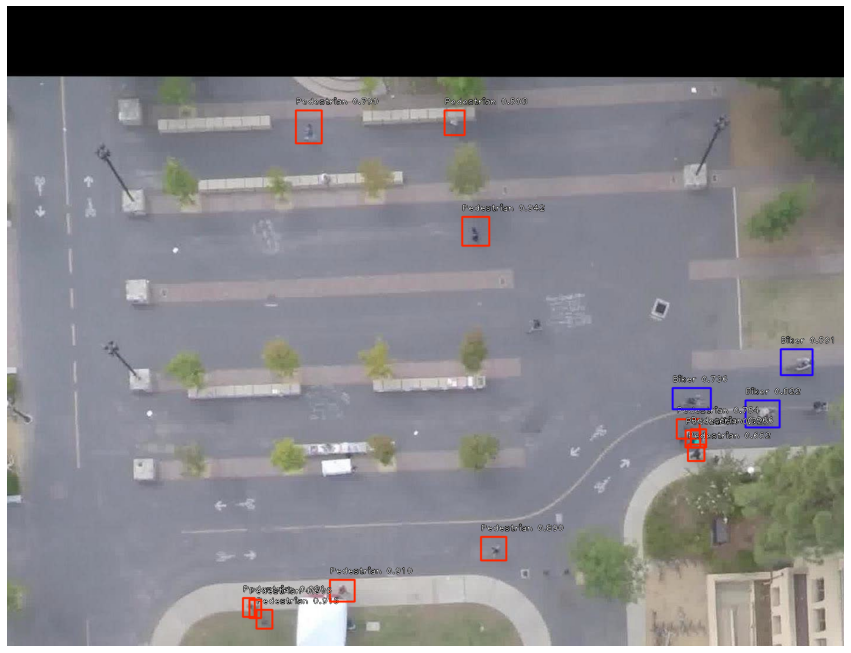

processing time:  1.4452478885650635


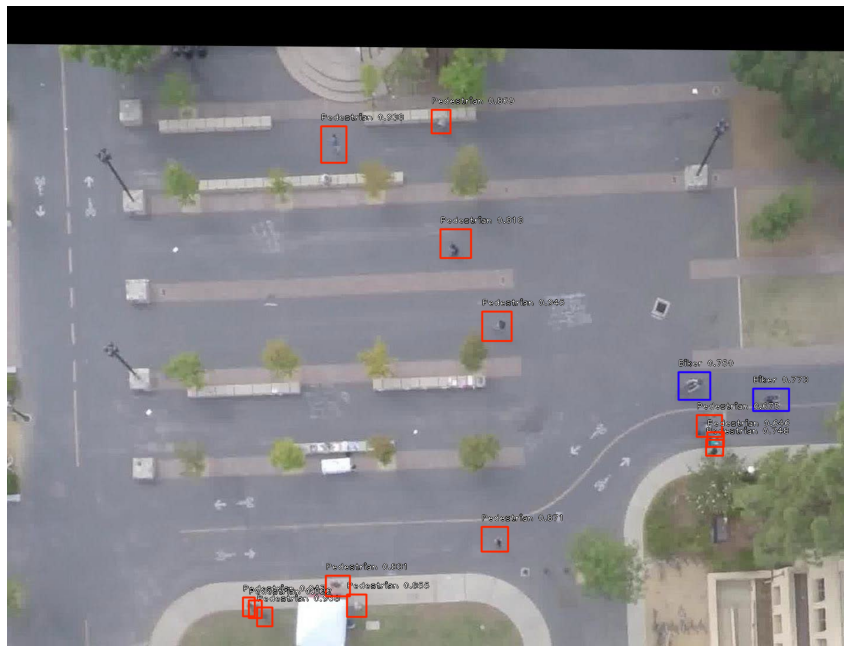

processing time:  1.2474756240844727


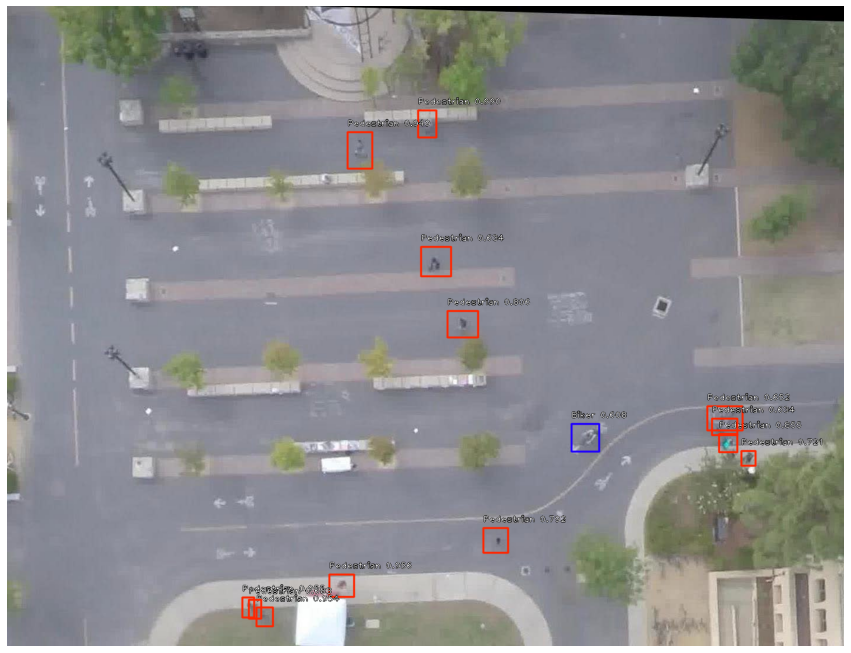

processing time:  1.2776503562927246


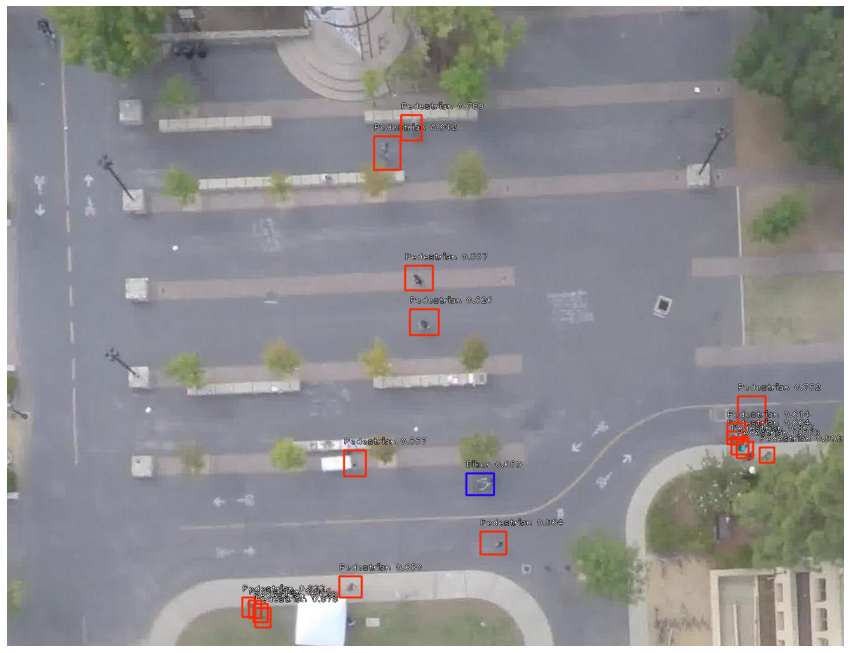

processing time:  1.2246787548065186


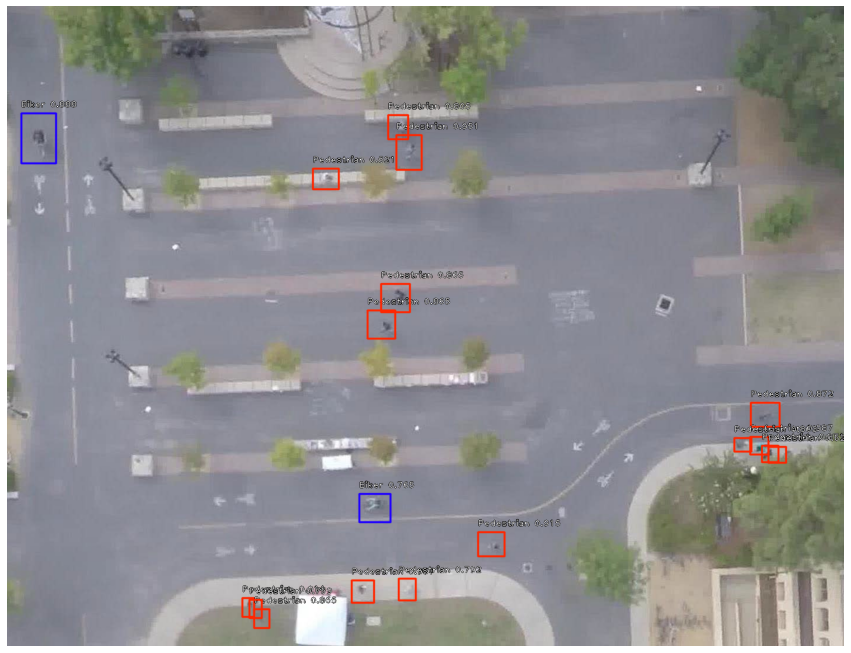

processing time:  1.2719058990478516


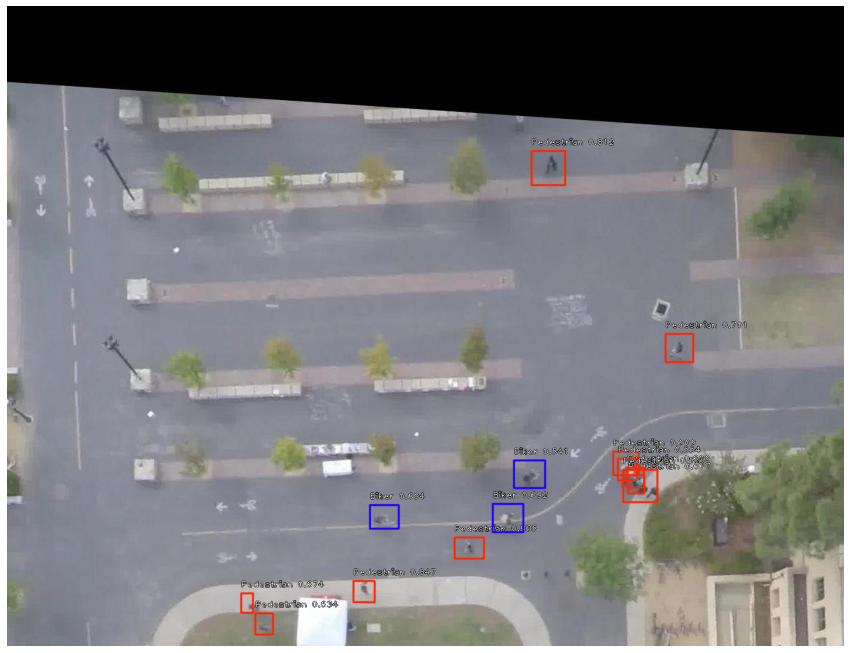

processing time:  1.2149336338043213


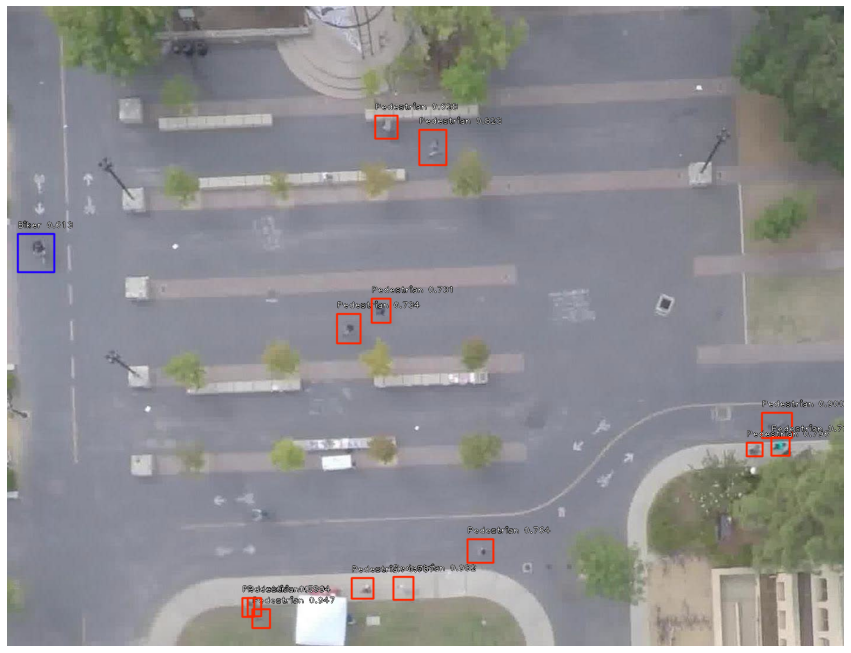

processing time:  1.1732115745544434


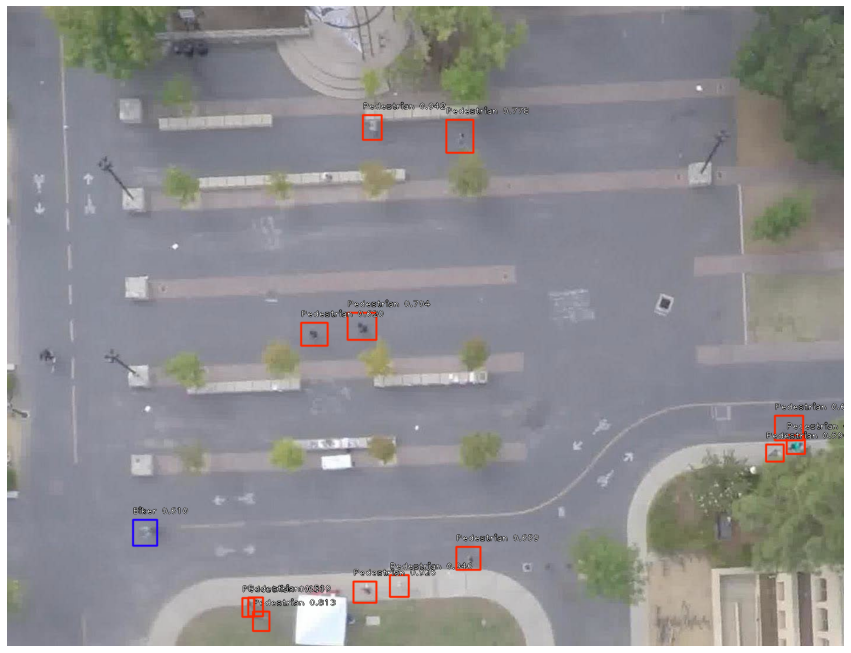

processing time:  1.2020153999328613


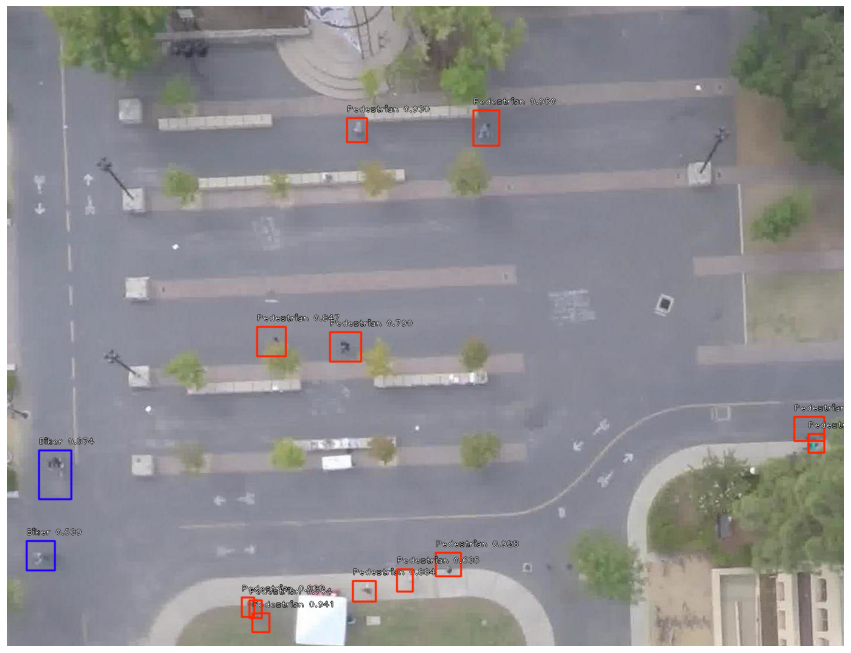

processing time:  1.190962553024292


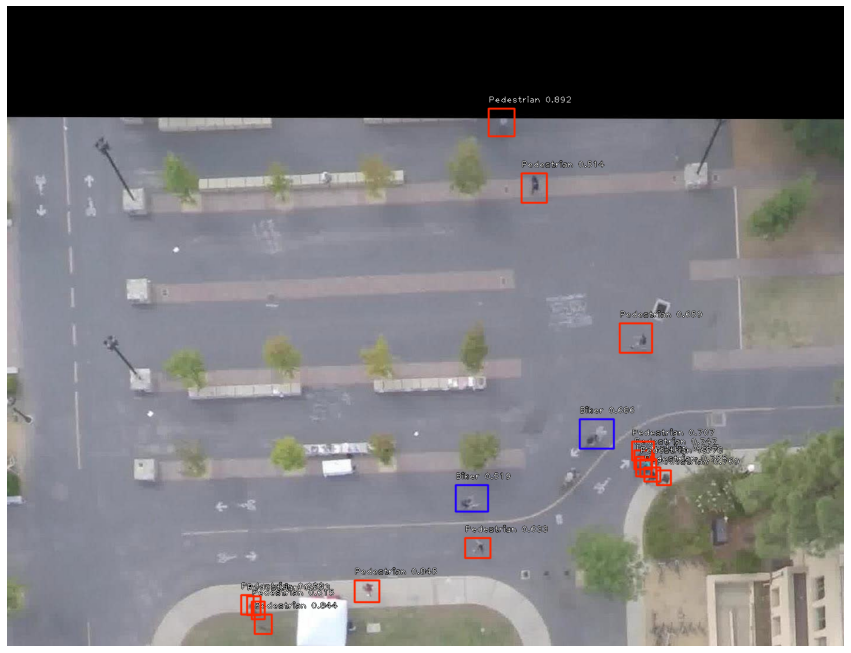

UnidentifiedImageError: cannot identify image file 'imgs/train\\desktop.ini'

In [49]:
base_path = 'imgs/train'
for image in sdd_images:
    run_detection_image(os.path.join(base_path,image))

In [59]:
import csv

In [60]:
annotations_file = 'train_annotations_full.csv'
cwd = os.getcwd()

image_names = []

with open (os.path.join(cwd, annotations_file)) as csvfile:
    readCSV = csv.reader(csvfile, delimiter='\n')
    for row in readCSV:
        vals = row[0].split(',')
        this_filepath = vals[0]
        image_names.append(this_filepath)
        
## remove duplicates by taking a set
image_names = list(set(image_names))
print(len(image_names))

11


In [61]:
print(image_names[:2])

['imgs/train/bookstore_video0_120.jpg', 'imgs/train/bookstore_video0_160.jpg']


In [62]:
score_threshold_retinanet = 0.4
acceptable_box_overlap = 0.3

In [63]:
def get_gt_annotations(filepath):
    gt_ann = []
    with open (os.path.join(cwd, annotations_file)) as csvfile:
        readCSV = csv.reader(csvfile, delimiter='\n')
        for row in readCSV:
            vals = row[0].split(',')
            this_filepath = vals[0]
            
            if this_filepath == filepath:
                record = []
                record.append(int(vals[1]))
                record.append(int(vals[2]))
                record.append(int(vals[3]))
                record.append(int(vals[4]))
                record.append(vals[5])
                
                gt_ann.append(record)
    return gt_ann

In [64]:
def bb_intersection_over_union(boxA, boxB):
	# determine the (x, y)-coordinates of the intersection rectangle
	xA = max(int(boxA[0]), int(boxB[0]))
	yA = max(int(boxA[1]), int(boxB[1]))
	xB = min(int(boxA[2]), int(boxB[2]))
	yB = min(int(boxA[3]), int(boxB[3]))
 
	# compute the area of intersection rectangle
	interArea = max(0, xB - xA + 1) * max(0, yB - yA + 1)
 
	# compute the area of both the prediction and ground-truth
	# rectangles
	boxAArea = (int(boxA[2]) - int(boxA[0]) + 1) * (int(boxA[3]) - int(boxA[1]) + 1)
	boxBArea = (int(boxB[2]) - int(boxB[0]) + 1) * (int(boxB[3]) - int(boxB[1]) + 1)
 
	# compute the intersection over union by taking the intersection
	# area and dividing it by the sum of prediction + ground-truth
	# areas - the interesection area
	iou = interArea / float(boxAArea + boxBArea - interArea)
 
	# return the intersection over union value
	return iou

In [65]:
def highest_iou(predicted_box, gt_ann):
    
    highest_iou = 0
    best_match = []
    for each_gt in gt_ann:
        this_iou = bb_intersection_over_union(predicted_box[:-1], each_gt[:-1])
#         print(" For this box is: ", this_iou)
        if this_iou > highest_iou:
            highest_iou = this_iou
            best_match = each_gt
            
    return highest_iou, best_match
        

In [66]:
def accuracy(gt_ann, predicted_ann):
    true_positive = []
    class_mismatch = []
    false_positive = []
    false_negative = []
    
    predicted_ann_copy = predicted_ann.copy()
    gt_ann_copy = gt_ann.copy()
    
    for each_pred in predicted_ann_copy:
        # 1. Calculate the highest_iou with any gt_box
        best_iou, best_gt_match = highest_iou(each_pred, gt_ann_copy)
#         print("Best IOU is: ", each_pred, best_gt_match, best_iou)
        
        ## If this box has a match
        if best_iou >= acceptable_box_overlap:
            ## if class label matches
            if best_gt_match[-1] == each_pred[-1]:
                ## This is a true positive
                true_positive.append(each_pred)
                ## remove this from predicted ann and gt
#                 print("Predicted Ann before:", predicted_ann)
                predicted_ann.remove(each_pred)
#                 print("Predicted Ann after:", predicted_ann)
                if best_gt_match in gt_ann:
                    gt_ann.remove(best_gt_match)
            elif best_gt_match[-1] != each_pred[-1]:
                ## this is a class mismatch
                class_mismatch.append(each_pred)
                ## remove this box
                predicted_ann.remove(each_pred)
                if best_gt_match in gt_ann:
                    gt_ann.remove(best_gt_match)
        
    ## If IOU is less than 0.5, leave as is

    ## Any predicted box is now false positive
    for remain_pred in predicted_ann:
        false_positive.append(remain_pred)

    ## Any remaining gt box is false negative
    for remain_gt in gt_ann:
        if remain_gt[-1] in ['Biker', 'Pedestrian', 'Car', 'Bus']:
            false_negative.append(remain_gt)

    return true_positive, class_mismatch, false_positive, false_negative       

In [67]:
def run_detection_image(filepath):
    image = read_image_bgr(filepath)

    # copy to draw on
    draw = image.copy()
    draw = cv2.cvtColor(draw, cv2.COLOR_BGR2RGB)

    # preprocess image for network
    image = preprocess_image(image)
    image, scale = resize_image(image)

    # process image
    start = time.time()
    boxes, scores, labels = model.predict_on_batch(np.expand_dims(image, axis=0))
    print("processing time: ", time.time() - start)

    # correct for image scale
    boxes /= scale
    
    gt_ann = get_gt_annotations(filepath)
    num_gt_ann = len(gt_ann)
    
    predicted_ann = []

    # visualize detections
    for box, score, label in zip(boxes[0], scores[0], labels[0]):
        # scores are sorted so we can break
        if score < score_threshold_retinanet:
            break
        record = []
        record.append(int(box[0]))
        record.append(int(box[1]))
        record.append(int(box[2]))
        record.append(int(box[3]))
        record.append(labels_to_names[label])
        print("Record is: ", record)
        predicted_ann.append(record)
    
    
#     print("predicted ann are: ", predicted_ann)
    ## Calculate boxes
    true_positive, class_mismatch, false_positive, false_negative = accuracy(gt_ann, predicted_ann)
    print(len(true_positive), len(class_mismatch), len(false_positive), len(false_negative))
    
    font = cv2.FONT_HERSHEY_SIMPLEX
    ## Draw theses on the image
    ## Draw true positive in green
    if len(true_positive) > 0:
        for each_true in true_positive:
            cv2.rectangle(draw,(each_true[0],each_true[1]),(each_true[2],each_true[3]),(0,255,0),3) #green
            cv2.putText(draw, each_true[-1], (each_true[0]-2, each_true[1]-2),font, 0.5,
                        (0,0,0),1,cv2.LINE_AA) # text in black
        
    ## Draw class mismatch in light blue   
    if len(class_mismatch) > 0:
        for each_mismatch in class_mismatch:
            cv2.rectangle(draw,(each_mismatch[0],each_mismatch[1]),(each_mismatch[2],each_mismatch[3]),(255,255,0),3) #green
            cv2.putText(draw, each_mismatch[-1], (each_mismatch[0]-2, each_mismatch[1]-2),font, 0.5,
                        (0,0,0),1,cv2.LINE_AA) # text in black
        
    
     ## Draw false positive  in blue 
    if len(false_positive) > 0:
        for each_fp in false_positive:
            cv2.rectangle(draw,(each_fp[0],each_fp[1]),(each_fp[2],each_fp[3]),(255,0,0),3) #green
            cv2.putText(draw, each_fp[-1], (each_fp[0]-2, each_fp[1]-2),font, 0.5,
                        (0,0,0),1,cv2.LINE_AA) # text in black
    
    
     ## Draw false negative in red 
    if len(false_negative) > 0:
        for each_fn in false_negative:
            cv2.rectangle(draw,(each_fn[0],each_fn[1]),(each_fn[2],each_fn[3]),(0,0,255),3) #green
            cv2.putText(draw, each_fn[-1], (each_fn[0]-2, each_fn[1]-2),font, 0.5,
                        (0,0,0),1,cv2.LINE_AA) # text in black
            
            
    ## Add key to the image
    cv2.putText(draw, "True Positive", (1200, 20),font, 0.8, (0,255,0),1,cv2.LINE_AA) 
    cv2.putText(draw, "Class Mismatch", (1200, 50),font, 0.8, (255,255,0),1,cv2.LINE_AA)
    cv2.putText(draw, "False Positive", (1200, 80),font, 0.8, (255,0,0),1,cv2.LINE_AA)
    cv2.putText(draw, "False Negtaive", (1200, 110),font, 0.8, (0,0,2550),1,cv2.LINE_AA)
    
    ### Save this image
    
    file, ext = os.path.splitext(filepath)
    image_name = file.split('/')[-1] + ext
    output_path = os.path.join('Outputs/train', image_name)
    
    draw_conv = cv2.cvtColor(draw, cv2.COLOR_BGR2RGB)
    cv2.imwrite(output_path, draw_conv)
    
    return len(true_positive), len(class_mismatch), len(false_positive), len(false_negative), num_gt_ann

    color = label_color(label)

    b = box.astype(int)
    draw_box(draw, b, color=color)

    caption = "{} {:.3f}".format(labels_to_names[label], score)
    draw_caption(draw, b, caption)

    plt.figure(figsize=(15, 15))
    plt.axis('off')
    plt.imshow(draw)
    plt.show()
    


In [68]:
total_true_positive = 0
total_class_mismatch = 0
total_false_positive = 0
total_false_negative = 0
total_gt = 0

In [69]:
for filepath in image_names:
    num_tp, num_cm , num_fp, num_fn, num_gt = run_detection_image(filepath)
    print("Ground Truth: ", num_gt)
    total_true_positive += num_tp
    total_class_mismatch += num_cm
    total_false_positive += num_fp
    total_false_negative += num_fn
    total_gt += num_gt

processing time:  1.1629679203033447
Record is:  [423, 1032, 452, 1066, 'Pedestrian']
Record is:  [792, 181, 836, 226, 'Pedestrian']
Record is:  [800, 902, 843, 942, 'Pedestrian']
Record is:  [398, 1003, 419, 1035, 'Pedestrian']
Record is:  [835, 302, 888, 351, 'Pedestrian']
Record is:  [991, 528, 1043, 577, 'Pedestrian']
Record is:  [1029, 690, 1088, 742, 'Biker']
Record is:  [1108, 763, 1137, 792, 'Pedestrian']
Record is:  [581, 983, 620, 1020, 'Pedestrian']
Record is:  [1091, 731, 1117, 762, 'Pedestrian']
Record is:  [1136, 771, 1157, 800, 'Pedestrian']
Record is:  [1099, 739, 1125, 769, 'Pedestrian']
Record is:  [895, 768, 950, 807, 'Biker']
Record is:  [412, 1009, 433, 1039, 'Pedestrian']
Record is:  [1091, 667, 1151, 719, 'Biker']
Record is:  [1089, 720, 1136, 768, 'Pedestrian']
Record is:  [1088, 715, 1120, 755, 'Pedestrian']
Record is:  [1103, 746, 1130, 776, 'Pedestrian']
18 0 0 0
Ground Truth:  16
processing time:  1.221498966217041
Record is:  [401, 1004, 421, 1038, 'Pedestr

processing time:  1.1567280292510986
Record is:  [398, 1001, 419, 1034, 'Pedestrian']
Record is:  [819, 174, 863, 221, 'Pedestrian']
Record is:  [591, 976, 633, 1013, 'Pedestrian']
Record is:  [421, 1034, 450, 1067, 'Pedestrian']
Record is:  [1070, 766, 1096, 799, 'Pedestrian']
Record is:  [1105, 789, 1129, 814, 'Pedestrian']
Record is:  [1084, 784, 1111, 808, 'Pedestrian']
Record is:  [1067, 755, 1097, 787, 'Pedestrian']
Record is:  [1063, 740, 1100, 772, 'Pedestrian']
Record is:  [974, 702, 1032, 752, 'Biker']
Record is:  [1042, 539, 1097, 589, 'Pedestrian']
Record is:  [779, 904, 822, 938, 'Pedestrian']
Record is:  [416, 1012, 438, 1042, 'Pedestrian']
Record is:  [408, 1003, 431, 1035, 'Pedestrian']
Record is:  [1077, 770, 1104, 800, 'Pedestrian']
Record is:  [763, 814, 818, 859, 'Biker']
Record is:  [875, 284, 918, 334, 'Pedestrian']
Record is:  [419, 1025, 444, 1056, 'Pedestrian']
Record is:  [760, 829, 810, 866, 'Biker']
Record is:  [778, 904, 824, 938, 'Biker']
19 1 0 1
Ground T

In [70]:
print(total_true_positive, total_class_mismatch, total_false_positive, total_false_negative, total_gt)

190 2 8 5 176


In [71]:
# 4763 687 2192 1067 5854

precision = total_true_positive/(total_true_positive+total_false_positive+total_class_mismatch)
recall = total_true_positive/(total_true_positive+ total_false_negative)
f1_score = 2*(precision * recall)/(precision + recall)

print(precision, recall, f1_score)

0.95 0.9743589743589743 0.9620253164556962
